In [3]:
%load_ext autoreload
%autoreload 2

from src.experiments.common import Experiment
from src.visualization.grad_variance_estimates import *
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from hydra.utils import instantiate
import seaborn as sns
from src.visualization.simulated import *
experiment = Experiment("sghmc_variance_estimators")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
m_run = experiment.latest_run()

def eval_poly(x, coeffs):
    return coeffs[0] + sum(c*x**i for i, c in enumerate(coeffs[1:], start=1))

dataset = instantiate(m_run.runs[0].config.data.dataset)
X, Y = dataset[:]

IndexError: list index out of range

In [5]:
posterior = get_exact_posterior(X, Y)
sample_data = pd.concat(
    load_samples(r)
    .reset_index(level=["sampler", "batch_size"], drop=True)
    .assign(
        variance_estimator=r.config["inference"]["sampler"]["variance_estimator"][
            "_target_"
        ]
    )
    .assign(
        variance_estimator=lambda x: x.variance_estimator.str.extract(
            "src.inference.mcmc.variance_estimators.(.+)"
        )
    )
    .set_index("variance_estimator", append=True)
    .reorder_levels(["variance_estimator", "sample"])
    for r in m_run.runs
    if "sampler" in r.config["inference"]
)


NameError: name 'X' is not defined

In [6]:
# for key, data in sample_data.groupby(level="variance_estimator"):
#     plot_sampled_distributions_pairs(data, exact_posterior=posterior)

In [7]:
sample_data.loc["ConstantEstimator"]

NameError: name 'sample_data' is not defined

In [2]:
i = 1
j = 3
joint_plots = {}

xlims = (-2.5, 1.0)
ylims = (0.1, 0.5)

with (sns.color_palette(PLOT_COLORS[("SGHMC", 5)]["color_palette"])):
    plot_sampled_joint_bivariate(
        sample_data.loc["ExpWeightedEstimator"][[i, j]],
        exact_posterior=posterior,
        xlims=xlims,
        ylims=ylims,
    )
    plt.savefig("simulated_joint_SGHMCWithVarianceEstimator_5.pdf")


NameError: name 'sample_data' is not defined

In [288]:
def get_data(path):
    data = torch.load(path)
    observed_variance = list(x["observed_variance"] for x in data["estimates"].values())
    estimated_variance = list(
        x["estimated_variance"] for x in data["estimates"].values()
    )
    step_index = pd.Index(data["estimates"], name="step")
    parameter_index = pd.Index(data["log_idx"].numpy(), name="parameter")

    return pd.concat(
        {
            "observed_variance": pd.DataFrame(
                torch.stack(observed_variance).numpy(),
                index=step_index,
                columns=parameter_index,
            ),
            "estimated_variance": pd.DataFrame(
                torch.stack(estimated_variance).numpy(),
                index=step_index,
                columns=parameter_index,
            ),
        },
        names=["name"],
    ).sort_index()

import re
def assign_var_estimator(data, run):

    estimator = run.config["inference"]["sampler"]["variance_estimator"]["_target_"]
    estimator = re.match("src.inference.mcmc.variance_estimators.(.+)", estimator)[1]
    return data.assign(variance_estimator = estimator)

gradient_data = pd.concat(
    get_data(run.path / "variance_estimates.pt")
    .pipe(assign_var_estimator, run=run)
    .set_index("variance_estimator", append=True)
    .reorder_levels(["variance_estimator", "step", "name"])
    .sort_index()
    for run in m_run.runs
)


In [289]:
def get_err_perc(x):
    err_perc =  (x["estimated_variance"] - x["observed_variance"]).abs() / x["observed_variance"]
    return err_perc

(
    gradient_data.unstack("name").reorder_levels([1,0], axis=1).groupby(level="parameter", axis=1)
    .apply(get_err_perc)
    .droplevel(0, axis=1)
    .groupby(level="variance_estimator")
    .mean()
    .to_latex("../thesis/Tables/simultated_variance_estimations.tex", float_format="%.2f")
)

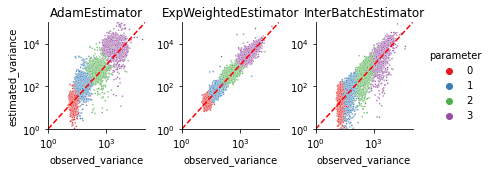

In [291]:
fg: sns.FacetGrid = (
    gradient_data
    .loc[lambda x: x.index.get_level_values("variance_estimator") != "ConstantEstimator"]
    .unstack(level="name")
    .stack("parameter")
    .reset_index()
    .pipe(
        (sns.relplot, "data"),
        x="observed_variance",
        y="estimated_variance",
        hue="parameter",
        col="variance_estimator",
        facet_kws={
            "sharex": False,
            "sharey": False,
        },
        palette="Set1",
        rasterized=True,
        marker=".",
        s=10,
        height=2.5,
        edgecolors=None,
        aspect=0.8
    )
)


for ax in fg.axes.flatten():
    ax.axline((1, 1), slope=1, color="red", linestyle="--")
    new_title = ax.title.get_text().split(" = ")[-1]
    ax.set_title(new_title)
fg.set(xlim=[1, 1e5], ylim=[1, 1e5], yscale="log", xscale="log")    
fg.tight_layout()
plt.savefig(f"../thesis/Figures/simulated_sghmc_gradient_variance_estimations.pdf")

In [292]:
def get_temperature_samples(run):
    samples = torch.load(run.path / "temperature_samples.pt")
    return (
        pd.DataFrame.from_dict(samples, orient="index")
        .unstack(1)
        .reorder_levels((1, 0), axis=1)
        .rename_axis(index="step", columns=["parameter", "value"])
    )

temperature_samples = pd.concat(
        get_temperature_samples(run)
        .pipe(assign_var_estimator, run=run)
        .set_index("variance_estimator", append=True)
        .reorder_levels([1, 0])
        for run in m_run.runs
    )

(
    temperature_samples
    .loc[:, "linear.weight"]
    .reset_index()
    .pipe(
        (sns.displot, "data"),
        x="temperature_sum",
        hue="variance_estimator",
        kind="hist",
        stat="density",
        common_norm=False
    )
)
plt.xlim(0, 40)
xx = np.linspace(0.01, 40, 300)
plt.plot(
    xx, torch.distributions.Chi2(4).log_prob(xx).exp(), color="black", linestyle="--"
)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11b0ac280> (for post_execute):


KeyboardInterrupt: 

In [293]:
from scipy.stats import chi2

def compute_99_chi2(x):
    df = x.index.get_level_values("n_params")[0]
    return (x < chi2(df).ppf(0.99)).mean()

(
    temperature_samples.stack(level="parameter")
    .set_index("n_params", append=True)
    .groupby(level=["variance_estimator", "parameter"])
    .agg(
        frac_in_99=pd.NamedAgg(
            "temperature_sum", aggfunc=compute_99_chi2
        )
    )
    .unstack("parameter")
)


,frac_in_99
parameter,linear.weight
variance_estimator,
AdamEstimator,0.968438
ConstantEstimator,0.803146
ExpWeightedEstimator,0.989236
InterBatchEstimator,0.985438
